# Final Report Mobile Robotics - Group 02


In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import constants
import camera
from IPython.display import Image, display
from IPython.display import Video




## 1 - Introduction 

In the context of the mobile robotics course's project, we worked on a Thymio robot in order to make it autonoumously navigate a changing environment. We created an environment that can be modifiable and a program which allows the thymio to adapt itself. We chose to make a simple environment (plain color floor and 2D red global obstacles) in order to be able to test different positions for the global obstacles and make our code as robust as possible.

We will explain in this report the choices we made to achieve our goals. We put an emphasis on the following areas, which will be explained in more details in the corresponding sections :
+ Computer Vision (collin)
+ Kalman Filtering (rose)
+ Navigation (zaynab)

We chose to develop a final state machine that allows the robot to navigate according to the situation it is facing (global and local navigation). Paired with computer vision and filtering to localise it self, our robot is able to plan a path and reach his goal while avoiding the unplanned obstacles it may encounter.


Below is a video of our robot in its environment avoiding local and global obstacles.

In [50]:

Video("maintest.mp4", embed=True)

# 2 - Computer Vision (Collin)

For our setup, we chose to use a blue background with red global obstacles. This provided a good contrast for our camera to pick up these obstacles cleanly. We also used Aruco markers to detect the static position of the goal, and the dynamic position of the robot.

Our setup looks as below:

Text(0.5, 1.0, 'Example image taken by camera of our setup')

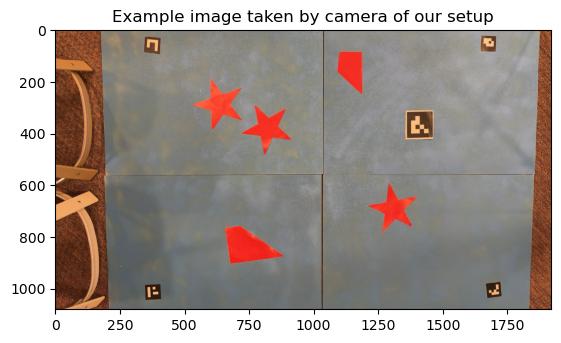

In [3]:
example_setup = cv2.imread('images/example_map.jpeg')
plt.imshow(cv2.cvtColor(example_setup, cv2.COLOR_BGR2RGB))
plt.title("Example image taken by camera of our setup")

Here, we can see the red shapes which are the global obstacles, the large aruco code which is our goal, and the small aruco markers which represent the bounds of our map for the Thymio.

In order to detect obstacles, we will do the following steps.

Firstly, we will convert our image to HSV format. This is done to more easily separate the red shapes from the blue background, and to easily eliminate any interference from the Aruco marker indicating the goal. We then create masks that represent the red hues we see on the HSV scale. We can see the red hues that we have by plotting a histogram of the hues present in our image.

(1080, 1920, 3)


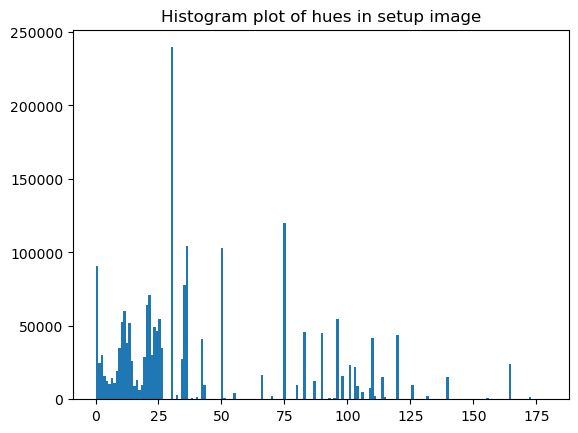

In [4]:
hsv_image = cv2.cvtColor(example_setup, cv2.COLOR_BGR2HSV)

fig, ax = plt.subplots(1)

print(hsv_image.shape)

ax.hist(hsv_image[:,:,0].ravel(), bins=180)
ax.set_title("Histogram plot of hues in setup image")
plt.show()

Here, we can see a concentration of hues between 0 and 25, corresponding to the red-like colours (the obstacles and the floor). We can filter out only the obstacles by considering hues between 0 and 10. We also include hues between 150 and 180 (on the other side of the colour wheel) as smetimes our red hues spill over to this side of the colour wheel. We also filter out all pixels that are of a low brightness, as we found that often the aruco markers were not filtered out without doing that. All 3 filters used are seen below, and are also seen combined as:

```
red_mask1 + red_mask2 - low_brightness_mask
```

with the resulting mask clipped so negative values are set to 1.

This thresholding idea was inspired by [this website](https://www.geeksforgeeks.org/color-identification-in-images-using-python-opencv/).

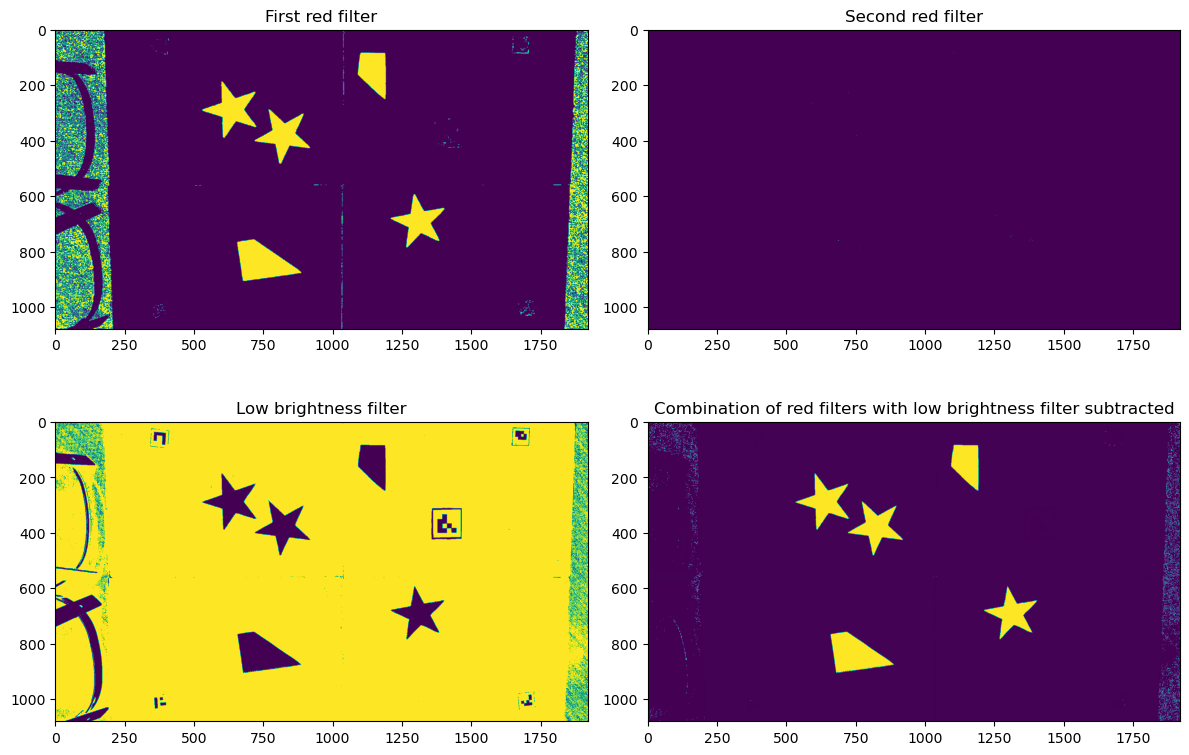

In [5]:
lower_red1 = np.array([0,50,50])
upper_red1 = np.array([10,255,255])

lower_red2 = np.array([160,50,50])
upper_red2 = np.array([180,255,255])

lower_v = np.array([0, 0, 0])
upper_v = np.array([255, 255, constants.V_TRESH])

red_mask1 = cv2.inRange(hsv_image, lower_red1, upper_red1)
red_mask2 = cv2.inRange(hsv_image, lower_red2, upper_red2)
low_brightness_mask = cv2.inRange(hsv_image, lower_v, upper_v)

mask = np.clip(red_mask1 + red_mask2 - low_brightness_mask, 0, None)

fig, axs = plt.subplots(2,2, figsize=(12,8))

axs[0,0].imshow(red_mask1)
axs[0,1].imshow(red_mask2)
axs[1,0].imshow(low_brightness_mask)
axs[1,1].imshow(mask)

axs[0,0].set_title("First red filter")
axs[0,1].set_title("Second red filter")
axs[1,0].set_title("Low brightness filter")
axs[1,1].set_title("Combination of red filters with low brightness filter subtracted")

fig.tight_layout()

We follow this up with a large Gaussian blur. This blur uses a size $15 \times 15$ Gaussian filter, as we have a high resolution image and only want to keep large items in our filtered image. The large filter will remove noise seen on the left and right of our final image. Finally we threshold this image to keep only pixels with value 255. This removes any small incorrectly detected 'obstacles', which may have come from the lines between our blue base boards, or from the floor. This blurring increases the robustness of the processing.

Text(0.5, 1.0, 'Thresholded image')

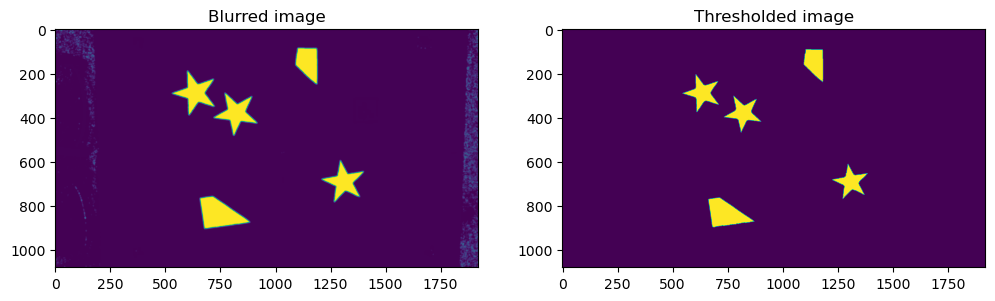

In [6]:
mask_blurred = cv2.GaussianBlur(mask, (15,15), 2, 2)
shapes = np.where(mask_blurred >= 255, mask_blurred, 0)

fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].imshow(mask_blurred)
axs[1].imshow(shapes)

axs[0].set_title("Blurred image")
axs[1].set_title("Thresholded image")


We then find the edges of the shapes that we output from our preprocessing step. We chose to use the `cv2.findContours()` function. This works well in our case as we use very regular shapes as obstacles, with clearly defined edges and corners. To use our path planning algorithm (Section 4) model the obstacles using the `cv2.approxPolyDP()` function, as it allows us to clearly define the corners of the shapes in our image and thus use Djikstra's algorithm to path plan.

The evolution of this process can be seen below:

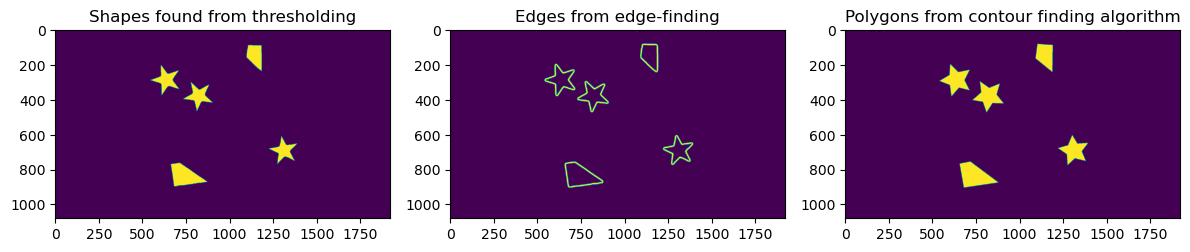

In [8]:
edges = camera.get_edges(shapes, threshold = 0.3, ksize = 5)
contours = camera.get_contours(edges, curve_sim=0.02)

shapes_image = np.zeros(edges.shape)
camera.draw_obstacles(shapes_image, contours)

fig, axs = plt.subplots(1,3,figsize=(12,6))

axs[0].imshow(shapes)
axs[1].imshow(edges)
axs[2].imshow(shapes_image)

axs[0].set_title("Shapes found from thresholding")
axs[1].set_title("Edges from edge-finding")
axs[2].set_title("Polygons from contour finding algorithm")

fig.tight_layout()

We calculate the edges with a smaller filter of size $5 \times 5$ as we now have very clear edges that we want to find and we can save on computational power with this. We also threshold with threshold value of $0.3$, which works well. We chose this value as it was the lowest value that worked consistently for us, even when some small noise still existed in the image.

We then find the polygons using the Douglas–Peucker algorithm. Our code was inspired by the openCV description of this function, found here: https://docs.opencv.org/4.x/dd/d49/tutorial_py_contour_features.html. This algorithm recursively eliminates points in the contour by checking their distance from the line segment defined by another two points.  $\varepsilon$ in this function acts as a guide to say if my point is within $\varepsilon$ of my line segment, that line segment can replace all points that are between its end points without significantly distorting the contour. If a point is farther away from the line segment than $\varepsilon$ then we must keep that point. A nice diagram describing the process can be seen at this [here](https://cartography-playground.gitlab.io/playgrounds/douglas-peucker-algorithm/). We only consider contours here that are longer than 300 pixels to again ensure we only look at our obstacles.

To identify Aruco markers, we used the built in `cv2` functions to create a detector and read the markers. We used the dictionary of `cv2.aruco.DICT_4X4_100` as we used 4x4 markers in our case. We simply pass the original frame to the detector with no processing and this suffices to detect the marker.


Text(0.5, 1.0, 'Image with markers indicated')

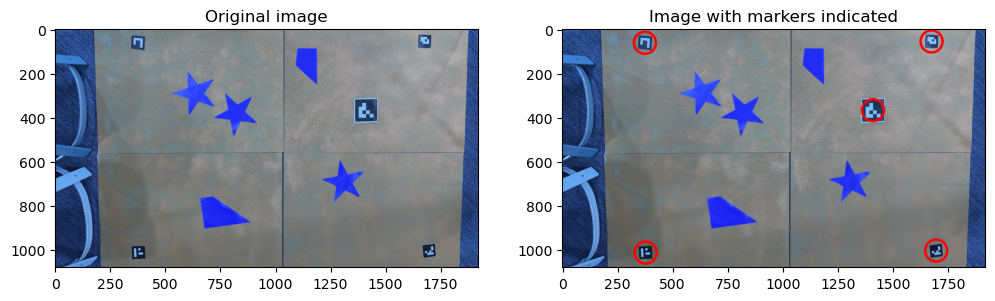

In [9]:
# This is the process used for finding aruco markers

aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_100)
aruco_params = cv2.aruco.DetectorParameters()
detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)

marker_corners, marker_ids, _ = detector.detectMarkers(example_setup)

marker_image = example_setup.copy()

for corners, id in zip(marker_corners, marker_ids):
    tl, tr, br, bl = corners[0]
    centre = tuple([int((tl[0]+br[0])/2), int((tl[1]+br[1])/2)])
    cv2.circle(marker_image, centre, 50, [255,0,0], 10)

fig, axs = plt.subplots(1,2, figsize=(12,6))

axs[0].imshow(example_setup)
axs[1].imshow(marker_image)

axs[0].set_title("Original image")
axs[1].set_title("Image with markers indicated")


The IDs of the aruco markers for both the goal and the Thymio are known in advance, as are the indices of the bordering aruco markers, and are declared in the `constants.py` file.

To do all of the preprocessing of obstacles, we can call the functions in the `camera.py` file as below:

In [10]:
obstacles = camera.find_obstacles(example_setup)

# 3 - Kalman Filtering (Rose)


## Theory

We decided to use an Extended Kalman Filter, because the motion model is non-linear. In fact, the Thymio can go straight in a linear manner but can also do rotationnal movements.

First of all, we had to define the state vector $x_k$. Here the vector $x_k$ contains the important information to allow the Thymio to localize itself. \
Therefore, we defined $x_k$ as follows: \
$x_k = \begin{bmatrix} p_{x_k} \\ p_{y_k} \\ v_k \\ \alpha_k \\ w_k \end{bmatrix}$ \
 (respectively the position in x, the position in y, the magnitude of the velocity, the direction angle and the angular velocity of the Thymio). \
\
The non-linear motion model  is defined as: 
$x_{k+1} = \begin{bmatrix} p_{x_k} + v_k cos(\alpha_k) T_s \\ p_{y_k} + v_k sin(\alpha_k) T_s \\ v_k \\ \alpha_k + w_k T_s \\ w_k \end{bmatrix}$ 

In this project, there are two distincts scenarios. \
The first one is when the camera is available. In this case, we get as measurements the values of the speed from the Thymio but also the position and the angle of the Thymio that we get from the camera. \
But, when the camera is obscured, we only have access to the speed values given by the Thymio. \
We therefore have to consider two different measurements $y_k = Hx_k + \nu_k$, one per scenario, where $\nu_k$ is the measurement noise with zero mean and covariance $R$.

1. When the camera is available (C), the measurement $y^C$ is given by:

      $y_k^C = H^Cx_k + \nu_k^C =  \begin{bmatrix} 1 & 0 & 0 & 0 & 0 \\ 0 & 1 & 0 & 0 & 0 \\ 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 0 & 1 \\\end{bmatrix}x_k+\nu_k^C$

      where $\nu_k^C$  is the measurement noise with zero mean and covariance $R^C$. \
      $R^C$ is a diagonal matrix because we assumed that the measurement noise of all the different measurements are independent. So we get $R^C = \begin{bmatrix} r_p & 0 & 0 & 0 & 0 \\ 0 & r_p & 0 & 0 & 0 \\ 0 & 0 & r_{nu} & 0 & 0 \\ 0 & 0 & 0 & r_{\alpha} & 0 \\ 0 & 0 & 0 & 0 & r_{rot} \\ \end{bmatrix}$ \
      Where $r_p$, $r_{nu}$, $r_\alpha$ and $r_{rot}$ are respectively the measurement variances of position, linear speed, angle, and rotational speed.

1. When the camera is not available (NC), the measurement $y^{NC}$ is given by:

      $y_k^{NC} = H^{NC}x_k + \nu_k^{NC} =  \begin{bmatrix} 0 & 0 & 1 & 0 & 0 \\ 0 & 0 & 0 & 0 & 1 \\\end{bmatrix}x_k+\nu_k^{NC}$. As for the first case, the measurement noise covariance matrix is assumed to be diagonal. So we get: $R^{NC} = \begin{bmatrix} r_{nu} & 0 \\ 0 & r_{rot} \\ \end{bmatrix}$

Finally, to implement the Kalman Filter, we also need to determine a sampling frequency $T_{s}$ and a process noise covariance matrix $Q$, which can also be assumed to be diagonal as $R$. \
So, we get $Q = \begin{bmatrix} q_p & 0 & 0 & 0 & 0 \\ 0 & q_p & 0 & 0 & 0 \\ 0 & 0 & q_{nu} & 0 & 0 \\ 0 & 0 & 0 & q_{\alpha} & 0 \\ 0 & 0 & 0 & 0 & q_{rot} \\ \end{bmatrix}$ 

## Choice of the sampling frequency $T_s$

We decided to put a sampling frequency equals to 0.3s, because our main loop where the extended kalman filter is called lasts about 2 to 2.5s. So we just took a value bigger than that and at the end of the main loop, we wait until the time of execution of the loop as reached the value of $T_s$. This ensures the sychronization and the consistency of the Kalman Filter accordingly to the sampling frequency we chose.

## Dealing with the speed of the Thymio

First of all, for the speed, we had to find a conversion factor for the linear as well as for the rotational speed. In fact, we have to convert the thymio units that we get from the wheels to a value in $mm/s$ for the linear velocity and to a value in $rad/s$ for the angular velocity.

### Linear velocity conversion factor

To do so, we just sampled the values that we get from the motors while the Thymio was going straight forward with a target value of 100 for both the left and right motors. Then, we can just calculate the conversion factor thanks to the formula $speed = \frac{distance}{time}$



In [27]:
distance = 900  #distance traveled by the Thymio in mm
time = 30 #duration of the movements in s

thymio_mms_speed = distance / time

print("The Thymio's speed in mm/s is {}".format(thymio_mms_speed))

The Thymio's speed in mm/s is 30.0


In [28]:
speed_thymio_units = 100   #Speed that we put into motor left and right target

thymio_speed_to_mms = thymio_mms_speed/speed_thymio_units
print("To go from Thymio speed to mm/s, the conversion factor is {}".format(thymio_speed_to_mms))

To go from Thymio speed to mm/s, the conversion factor is 0.3


### Angular velocity conversion factor

We did exactly the same to determine the angular velocity conversion factor by setting this time the left and right motor target to respectively 50 and -50.

In [29]:
angle = 10  #in rad    
time = 30   #in s

thymio_rads_speed = angle / time

print("The Thymio's speed in rad/s is {}".format(thymio_rads_speed))

The Thymio's speed in rad/s is 0.3333333333333333


In [30]:
speed_thymio_units = 50   #Speed that we put into motor left and right target

thymio_speed_to_rads = thymio_rads_speed/speed_thymio_units
print("To go from Thymio speed to rad/s, the conversion factor is {}".format(thymio_speed_to_rads))

To go from Thymio speed to rad/s, the conversion factor is 0.006666666666666666


Even with the conversion factors we calculated, we had trouble to well define the linear and angular velocity from the Thymio units. In fact, with only the values of the motor left and right speed, we have to estimate to different velocities. \
So we decided to distinguish between five cases. 

1. The thymio is going straight forward \
This case occurs when the motor right and left speeds are equals. The state is updated through the motion model with an average linear velocity equals to the average speed of the left and the right motor speeds, and the average rotationnal speed is set to zero.

2. The thymio is pivoting left (without movement forward) \
This case occurs when the absolute values of the motor right and left speeds are equals, while the motor left speed value is negative. The state is updated through the motion model with an average angular velocity equals to the negative value of the average speed of the absolute value of the left and the right motor speeds, and the average linear speed is set to zero.

3. The thymio is pivoting right (without movement forward) \
This case occurs when the absolute values of the motor right and left speeds are equals, while the motor right speed value is negative. The state is updated through the motion model with an average angular velocity equals to the positive value of the average speed of the absolute value of the left and the right motor speeds, and the average linear speed is set to zero.

4. The thymio is turning left (with movement forward) \
This case occurs when the motor right speed value is greater than the motor left speed value. The state is updated through the motion model with an average angular velocity equals to the negative value of the average speed of the absolute value of the left and the right motor speeds. The average linear speed is set to the average speed of the left and the right motor speeds. 

5. The thymio is turning right (with movement forward) \
This case occurs when the motor left speed value is greater than the motor right speed value. The state is updated through the motion model with an average angular velocity equals to the positive value of the average speed of the absolute value of the left and the right motor speeds. The average linear speed is set to the average speed of the left and the right motor speeds. 


### Troubling with the estimated angle

We also remarked that we have to take care of the sign of the average angular velocity in order to have an accurate estimation of the angle of the robot. In fact, each time the Kalman Filter is called, the state of the robot (position, linear speed, angle, rotationnal speed) is updated through the motion model as follows: \
\
$x_{k+1} = \begin{bmatrix} p_{x_k} + v_k cos(\alpha_k) T_s \\ p_{y_k} + v_k sin(\alpha_k) T_s \\ v_k \\ \alpha_k + w_k T_s \\ w_k \end{bmatrix}$ \
\
So, we can see that the updated angle depends on the angular velocity. At the beginning, we always put an average angular velocity that was positive (average of the absolute values of the motor left and right speeds). But, with this, the robot always wanted to turn right, i.e. the estimated angle wasn't accurate. \
In fact, as the average omega is always calculated with the absolute values of the motor left and right speed, omega was always positive and the updated angle was always bigger than the previous one. But this is only true if the robot is turning right (see schema below). \
To resolve this, we just put a minus sign to the average omega when the robot is turning left and we keep the positive value of average omega when the robot is turning right.



(-0.5, 1599.5, 881.5, -0.5)

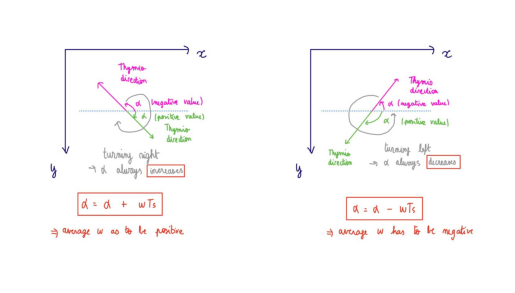

In [47]:
rose = cv2.imread('images/rose.jpg')
plt.imshow(cv2.cvtColor(rose, cv2.COLOR_BGR2RGB))
plt.axis('off')  

## Finding the right values for the covariance matrices 

### Variance of linear speed state and measurements

We made the thymio advance at a constant speed while storing at regular intervals the values ​​of the right and left motors returned by the thymio. Then we calculate the average of the speeds between the right motor and the left motor. And finally, we just calculate the variance of this vector of average speeds over time. \
We assumed that half of the variance is caused by the measurements and half is caused by perturbations to the states, this gives us : \
$q_\nu = \frac{speedvariance}{2}  mm^2/s^2$ \
$r_\nu = \frac{speedvariance}{2}  mm^2/s^2$

### Variance of rotational speed state and measurements

We did exactly the same to calculate the variance in the rotational speed. The thymio was rotated at a constant speed, while storing at regular intervals the values ​​of the right and left motors returned by the thymio. We just had to be careful to take the absolute values ​​of the speeds of the right and left motors to don't get an average speed equals to zero

### Variance of position state and measurements

We just made a vector with the x and y values of the position of the Thymio given by the camera ​during 30 seconds without moving either the camera or the thymio. And then we calculated the variance between the values ​​of this vector.

### Variance of angle state and measurements 

As for the position, we just made a vector with the angle value of the Thymio given by the camera ​during 30 seconds without moving either the camera or the thymio. And then we calculated the variance between the values ​​of this vector.

## Results 

The Kalman Filter we implemented allows the thymio to localize itself for a few seconds without the information from the camera (i.e. only with odometry)

In [ ]:

Video("kalman.mp4", embed=True)

# 4 - Navigation (Zaynab)

Computer vision and filtering are providing an accurate estimation of the robot, the goal and the global obstacles positions. This being done, we can now move the robot around, avoiding global and local obstacles. An optimal path of points is calculated to do that. 

Our final state machine is switching between the states PATH_FOLLOWING and LOCAL_AVOIDANCE. During PATH_FOLLOWING, we use a PID controller to follow a straight line between two points in the calculated optimal path. When an obstacle is detected the function test_obst() makes the state change into LOCAL_AVOIDANCE which navigates using the sensors only.  

+ ## 4.1 Global Navigation
    + #### Path planning
        ## Build a visibility graph
        To find the optimal path, we build a visbility graph using the networkx python librairie. We had to define the nodes as well as the edges of our visibility graph. 
        1. Nodes: \
        The corners of the obstacles are added as nodes of the graph.
        The start point and the goal point are also added.
        2. Edges: \
        An edge is added between two nodes if there is a direct path between them (no intersection with an obstacle).
        The distance between two nodes is calculated with the Euclidean norm, it represents the weight of the edge.

        The four markers on the grounds are representing the corners of the frame and the points which are not within those boundaries are not included in the optimal path finding.    
        ## Dijkstra Search
        We decided to use the Dijsktra algorithm to find the optimal path from start to goal using the visibility graph.
        1. Initialization: \
        The distances of all nodes are initialized to infinity, except for the starting node whose distance is 0.
        A list of predecessors is intialized to be then used to reconstruct the path.
        A list of visited nodes is also initialized to keep track of which node has been visited or not.
        2. Search: \
        At each iteration, the unvisited node with the smallest distance is selected.
        The distances of its neighbors are updated if a shorter distance is found.
        3. Path reconstruction: \
        When we arrive to the goal, the path is reconstructed by tracing the predecessors back from the arrival point.

        ##### Enlargement of obstacles : 
        Before building the visibility graph and applying the dijkstra algorithm, we had to extend the obstacles that we get from computer vision to take into account the size of the robot. We used the function buffer() of the python librairy shapely.
    <br><br>
    <br><br>

    + #### PID
    In order to make the robot follow its path, we chose to control the angle of the robot. The PID controller is used to minimise the error on the direction by calculating an angle difference between the target goal direction and the thymio direction, which is considered as the error, and minimising it.
    <br><br>
    

(-0.5, 501.5, 453.5, -0.5)

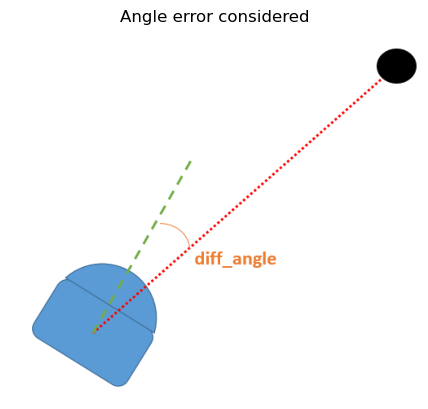

In [48]:
angle_scheme = cv2.imread('images/scheme_diffangle.png')
plt.imshow(cv2.cvtColor(angle_scheme, cv2.COLOR_BGR2RGB))
plt.title("Angle error considered")
plt.axis('off')  

Target direction (in red) is the line between the thymio and the next point in the path and the actual direction of the robot (in green) is where the robot is heading to if there is no control. So we consider the diff_angle to be the error our PID controller is going to minimize. 

$ PIDeff = K_p \cdot anglediff + K_i \cdot errsum \cdot dt + K_d \cdot \frac{minuserr}{dt} $

This calculates the output PIDeff of the PID controller, which determines the effect on the robot's speed. This output will be used to adjust the robot's movement, minimizing the angular difference. Doing tests with multiple values of dt, we we chose a dt that ensures an acurate integration and derivation.


Our first idea to tune the PID using the Ziegler-Nichols' method but that required to calculate the critical oscilation period. However we were not able to reach the critical point were there was a stable oscillation using Kp only so we chose to tune the PID manually. The goal was to find the Kp where the robot starts responding sufficiently to the error maintaining Ki and Kd null, we then incrementally adjusted Ki to eliminate steady-state error and tuned Kd to dampen overshoot and improve system stability, reducing oscillations caused by abrupt changes. We ended up with the values 10, 3 and 1 for, respectively, Kp, Ki and Kd.

Without the Kalman filter and when the camera is always on and the thymio always seen, the PID is smoothly bringing the robot back to its path. The small variances than can be seen are due to the location being lost and calculated with odometry which is less precise.

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\HP\AppData\Local\Temp\ipykernel_16588\3222763676.py:1: SyntaxWarning: invalid escape sequence '\P'
  angle_scheme = cv2.imread('images\PID_angle diff.png')


(-0.5, 764.5, 537.5, -0.5)

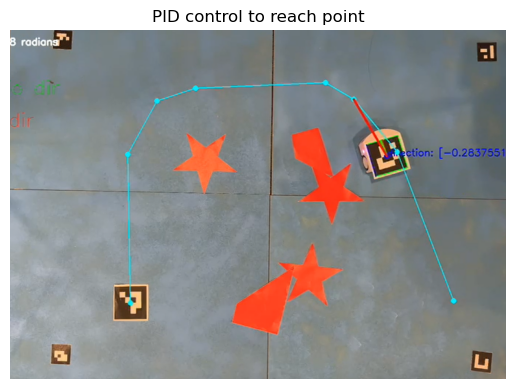

In [49]:
angle_scheme = cv2.imread('images\PID_angle diff.png')
plt.imshow(cv2.cvtColor(angle_scheme, cv2.COLOR_BGR2RGB))
plt.title("PID control to reach point")
plt.axis('off')  

As we can see in the image the thymio is not completely aligned with the target direction (in red) but the PID control will make the robot reach its goal sucessfully.

+ ## 4.2 Local Navigation

When an obstacle is encountered, the state changes to OBSTACLE_AVOIDANCE which forces the thymio to navigate only using the sensors.

The function obstacle_avoidance is called and makes the robot avoid the obstacle depending on the data that is collected by the sensors which cointains information about the position of the obstacle according to the robot. Depending on wether an obstacle is seen in the center, or more on the left or right, the robot will act accordingly and for that we make it use the five horizontal sensor at the front of the robot and turn the oposite side of the obstacle. 

However, since the robot doesn't have any sensors on the sides, we are making it go straight for a small amount of time for it to avoid the obstacle sucessfully. We chose to recalculate the optimal path after the local obstacle was avoided using the sensors. This way we can increase the robustness of our program and its adaptability to different environments. Anyways our local obtacles are not processed by the computer vision because they do not correspond to any of the choices we made for frame processing, thus we are sure that we only navigate locally using the sensors.



<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:7: SyntaxWarning: invalid escape sequence '\o'
<>:8: SyntaxWarning: invalid escape sequence '\o'
<>:9: SyntaxWarning: invalid escape sequence '\o'
<>:10: SyntaxWarning: invalid escape sequence '\o'
C:\Users\HP\AppData\Local\Temp\ipykernel_16588\604501996.py:6: SyntaxWarning: invalid escape sequence '\o'
  "images\obst_avoidance_1.png",
C:\Users\HP\AppData\Local\Temp\ipykernel_16588\604501996.py:7: SyntaxWarning: invalid escape sequence '\o'
  "images\obst_avoidance_2.png",
C:\Users\HP\AppData\Local\Temp\ipykernel_16588\604501996.py:8: SyntaxWarning: invalid escape sequence '\o'
  "images\obst_avoidance_3.png",
C:\Users\HP\AppData\Local\Temp\ipykernel_16588\604501996.py:9: SyntaxWarning: 

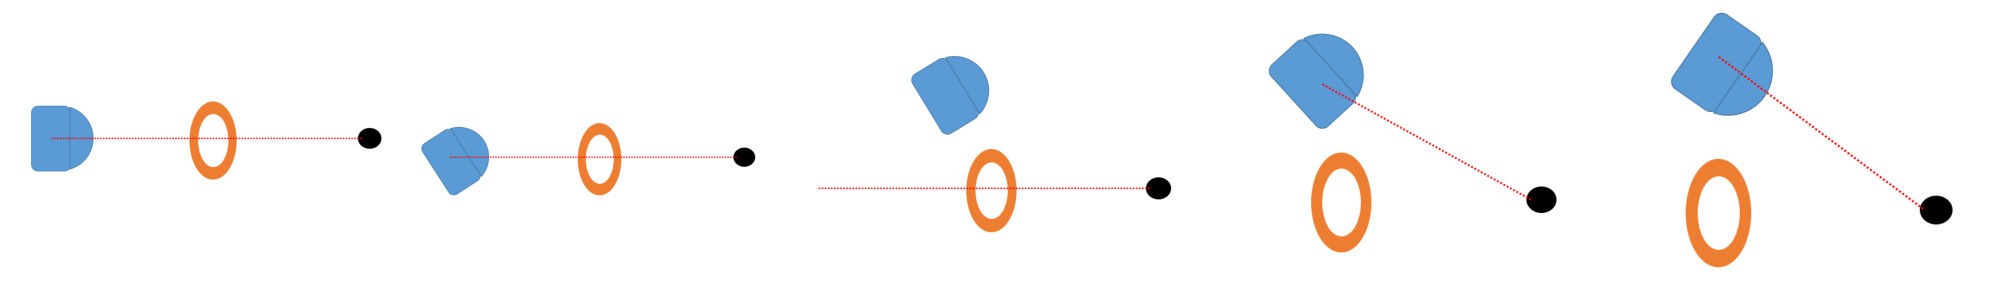

In [26]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# List of image file paths
image_paths = [
    "images\obst_avoidance_1.png",
    "images\obst_avoidance_2.png",    
    "images\obst_avoidance_3.png",
    "images\obst_avoidance_4.png",
    "images\obst_avoidance_5.png",
]

# Set the figure size and create subplots
fig, axes = plt.subplots(1, 5, figsize=(20, 4))  # 1 row, 5 columns

# Loop through the images and plot them
for ax, img_path in zip(axes, image_paths):
    img = mpimg.imread(img_path)  # Read the image
    ax.imshow(img)                # Show the image
    ax.axis("off")                # Turn off the axis for clean display

plt.tight_layout()  # Adjust spacing between images
plt.show()


We can see in the drawing the steps our robot follows to avoid the local obstacle, he will only recalculate the path when reaching step 4 (not seeing any obstacle anymore).

# 5 - Our code 

You can find our code in the file 'FSM.ipynb' ready to be ran (the one we used). We copied it below too.

We used the exercices and solution provided by the professor as a base for our project and for some of the functions we used. Other references are cited in the report.

In [1]:
import GlobalNavigation as globnav
import ExtendedKalmanFilter as EKF
import camera as cam
import cv2
import numpy as np
import math
from tdmclient import ClientAsync, aw
import constants
import time

In [ ]:
client = ClientAsync()
node = await client.wait_for_node()
await node.lock()

In [ ]:
PATH_FOLLOWING = 0
LOCAL_AVOIDANCE = 1

state = PATH_FOLLOWING
prev_state = PATH_FOLLOWING

In [ ]:
def distance_between(p1, p2):
    delta_x = p1[0] - p2[0]
    delta_y = p1[1] - p2[1]
    return math.sqrt(delta_x**2 + delta_y**2)

In [ ]:
def motors(l_speed=100, r_speed=100, verbose=False):
    """defining the motor speeds and printing them if necessary for debugging puposes

    Args:
        l_speed (int, optional): left speed. Defaults to 100.
        r_speed (int, optional): right. Defaults to 100.
        verbose (bool, optional): debugging. Defaults to False.

    """
    if verbose:
        print("\t\t Setting speed : ", l_speed, r_speed)
    return {
        "motor.left.target": [l_speed],
        "motor.right.target": [r_speed],
    }

In [ ]:
async def test_obst(obst_threshold, verbose=False):
    """is there any obstacle, independantly on which sensor is sensing it?

    Args:
        obst_threshold (_type_): obstacle threshold
        verbose (bool, optional): debugging. Defaults to False.

    """
    
    await node.wait_for_variables({'prox.horizontal'})
    prox_horizontal = list(node['prox.horizontal'])

    if verbose :
        if prox_horizontal is None:
            print("Failed to fetch sensor data.")
        else:
            print("Sensor data fetched successfully:", prox_horizontal)

    for value in prox_horizontal:
        if value>obst_threshold :
            if verbose: print("\t\t Saw an obstacle")
            return True
    
    return False

In [ ]:
async def check_state ():
    """
    returns the state it is in
    
    """
    if await test_obst(0, False) :
        state = LOCAL_AVOIDANCE
    else:
        state = PATH_FOLLOWING
    return state

In [ ]:
def PID(Kp =10, Ki=3, Kd=1, maxerr=40, minuserr=0, prev_err=0, err_sum=0, angle_diff=0): 
    """
    Returns:
        returns the PID output that we can directly apply to the motors speed
    """
    ## enft on a tester un PD, test PID now
    err_sum += angle_diff
    minuserr = angle_diff-prev_err
    
    dt = 0.02

    #tester sans
    if err_sum> maxerr:
        err_sum = maxerr
    if err_sum < -maxerr:
        err_sum = -maxerr

    PID_eff = Kp*angle_diff + Ki * err_sum * dt + Kd*minuserr / dt
    prev_err=angle_diff

    
    
    return PID_eff, maxerr, minuserr, prev_err, err_sum

In [ ]:

async def path_following(motor_speed, path, loc, angle, next_idx, Kp, Ki, Kd, maxerr, minuserr, prev_err, err_sum):
    
    current_x, current_y = loc
    current_angle = angle
    goal_x, goal_y = path[next_idx]

    # Calculate heading to the waypoint
    delta_x = current_x - goal_x
    delta_y = current_y - goal_y
    
    target_angle = math.atan2(delta_y, delta_x) # Angle to current waypoint
    angle_diff = (current_angle - target_angle ) + np.pi # Normalize angle
    
    #to do the smallest turn  
    if angle_diff > math.pi:
        angle_diff = angle_diff - 2*math.pi
    elif angle_diff < -math.pi:
        angle_diff = angle_diff + 2*math.pi
    
    PID_eff, maxerr, minuserr, prev_err, err_sum = PID(Kp, Ki, Kd, maxerr, minuserr, prev_err, err_sum, angle_diff)
    
    prev_err=angle_diff

    await node.set_variables(motors(int(motor_speed - PID_eff), int(motor_speed + PID_eff) ))

    prev_state = PATH_FOLLOWING

    return prev_state

        

In [ ]:
async def straight(motor_speed, t):
    await node.set_variables(motors(motor_speed, motor_speed))
    await client.sleep(t)

async def turn_right(motor_speed, t):
    await node.set_variables(motors(motor_speed, 0))
    await client.sleep(t)
    
async def turn_left(motor_speed, t):
    await node.set_variables(motors(0, motor_speed))
    await client.sleep(t)
    
async def piv_right(motor_speed, t):
    await node.set_variables(motors(motor_speed, -motor_speed))
    await client.sleep(t)
    
async def piv_left(motor_speed, t):
    await node.set_variables(motors(-motor_speed, motor_speed))
    await client.sleep(t)
    
async def go_back(motor_speed, t):
    await node.set_variables(motors(-motor_speed, -motor_speed))
    await client.sleep(t)


In [ ]:
async def obst_avoidance(motor_speed, obst_threshold, verbose):
    """
    obstacle avoidance behaviour of the FSM
    param motor_speed: the Thymio's motor speed
    param obst_threshold: threshold starting which it is considered that the sensor saw an obstacle
    param verbose: whether to print status messages or not
    """
      
    prox_horizontal = list(node['prox.horizontal'])

    ### here faire pour chaque sensor
    left = prox_horizontal[0]
    centeredleft = prox_horizontal[1]
    center = prox_horizontal[2]
    centeredright = prox_horizontal[3]
    right = prox_horizontal[4]
    
    # detect in the middle
    if center != 0:
        await piv_left(motor_speed, 0.1)
    
    # detect on the LEFT
    if left != 0: 
        await piv_right(motor_speed, 0.1)
        await straight(motor_speed, 1)
        
    # detect on the RIGHT
    if right != 0: 
        await piv_left(motor_speed, 0.1)
        await straight(motor_speed, 1)

    # in LEFTCENTER
    if centeredleft != 0: 
        await piv_right(motor_speed, 0.1)

    # detect on the RIGHT
    if centeredright != 0: 
        await piv_left(motor_speed, 0.1)
        
    if centeredleft > centeredright: 
        await piv_right(motor_speed, 0.1)
        
    if centeredright > centeredleft: 
        await piv_left(motor_speed, 0.1)

    await client.sleep(0.1) #otherwise, variables would not be updated
    
    prev_state = LOCAL_AVOIDANCE
    
    return prev_state

In [ ]:
async def main_FSM(speed, obst_threshold, verbose=False):

    #DEFINING GLOBAL VARIABLES
    global_path_found = False  #to read the path only when needed
    next_idx = 1 #path 
    minuserr, prev_err, err_sum =0,0,0 # for PID, to accumulate error
    loc = None 
    goal = None
    angle = None
    dir_vec = None
    
    
    #VISION AND PLOTTING
    vision = cv2.VideoCapture(0)

    cv2.namedWindow("test", cv2.WINDOW_AUTOSIZE)
    cv2.namedWindow("drawing", cv2.WINDOW_AUTOSIZE)
    cv2.startWindowThread()
    
    for i in range(60):
        ret, bin_frame = vision.read()
        
    #first reading global obstacles
    _, obstacles_frame = vision.read()
    obstacles = cam.find_obstacles(obstacles_frame)

    frame_width = int(vision.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(vision.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Define the codec and create VideoWriter object (for video)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    output = cv2.VideoWriter('output.mp4', fourcc, 30.0, (frame_width, frame_height))

    # detector for arucode
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_100)
    aruco_params = cv2.aruco.DetectorParameters()
    detector = cv2.aruco.ArucoDetector(aruco_dict, aruco_params)

    # bound not to go out of frame
    bounds = cam.get_bounds(obstacles_frame, detector)
    
    #initialisation for Kalman filter
    loc, dir_vec, angle, thymio_corners, goal = cam.live_pos(obstacles_frame, detector, constants.THYMIO_ID, constants.GOAL_ID)  # position given by the localization function
    x_est = [np.array([[loc[0]], [loc[1]], [0], [0], [0]])]   
    P_est = [1000 * np.ones(5)]                                                
    camera_available = False                                  
  
    while True:
        
        start_time = time.time()  #to synchronize the kalman filter and data sampling
        
        _, frame = vision.read()

        blank_frame = np.zeros(frame.shape)

        new_loc, new_dir_vec, new_angle, thymio_corners, new_goal = cam.live_pos(frame, detector, constants.THYMIO_ID, constants.GOAL_ID)  # position given by the localization function
        
        if new_loc is None:
            camera_available = False 
        else:
            camera_available = True 
        
        aw(client.sleep(0.1))
        await node.wait_for_variables() # wait for Thymio variables values
        
        new_x_est, new_P_est = EKF.extended_kalman_filter(node["motor.left.target"], node["motor.right.target"], 
                                                          new_loc, new_angle, x_est[-1], P_est[-1], camera_available) # starting to use the kalman filter
        
        #adding the new estimation to the list of estimations
        x_est.append(new_x_est)
        P_est.append(new_P_est)
        
        new_x_est = tuple(new_x_est.flatten())
        new_P_est = tuple(new_P_est.flatten())

        loc = (int(new_x_est[0]),int(new_x_est[1])) # location estimated by kalman filtering

        angle = (new_x_est[3]) # angle estimated by kalman filtering
        dir_vec = EKF.get_vector_from_angle(angle) #director vector estimated by kalman filtering

        if new_goal is not None:
            goal = new_goal

        #getting global path once
        if global_path_found == False:
            path = cam.live_path(obstacles, loc, goal, constants.THYMIO_SIZE, bounds) ## here using filtering?
            global_path_found= True

        #plotting
        cam.live_drawing(frame, blank_frame, thymio_corners, obstacles, path)

        distance_to_goal = distance_between(loc, path[next_idx])

        if distance_to_goal < 100:  # Threshold for reaching next point
            next_idx += 1  # next point
            if next_idx >= len(path) and distance_to_goal >= constants.THRESHOLD_TO_GOAL:
                    await node.set_variables(motors(speed,speed))
                    next_idx=next_idx-1
            if distance_to_goal < constants.THRESHOLD_TO_GOAL:
                await node.set_variables(motors(0, 0)) # if reached final goal stop the thymio and go out of function
                vision.release()
                cv2.destroyAllWindows()
                output.release()
                return

        # Step 1: path following (for now going straight) global nav
        if await check_state()== PATH_FOLLOWING:
            prev_state = await path_following(speed, path, loc, angle, next_idx, 10, 3, 1, 40, minuserr, prev_err, err_sum) #maxSum et Kp par tatonement 

        # Step 2: obst following local nav
        if await check_state() == LOCAL_AVOIDANCE:
            prev_state = await obst_avoidance(speed, obst_threshold, verbose)

        #recalculating path after local avoidance
        if prev_state == LOCAL_AVOIDANCE and await check_state()==PATH_FOLLOWING:
            path = cam.live_path(obstacles, loc, goal, constants.THYMIO_SIZE, bounds)
            next_idx = 1
        
        #plotting
        goal_dir = (int(loc[0] + 50*dir_vec[0]) , int(loc[1] + 50*dir_vec[1]))

        cv2.circle(frame, loc, 5, [255,0,0], 5)
        cv2.line(frame, loc, goal_dir, [0,255,0], 5)
        cv2.line(frame, loc, path[next_idx], [0,0,255], 5)
        cv2.putText(frame, "{} radians".format(angle), (50,50), cv2.FONT_HERSHEY_SIMPLEX, 1, [255,255,255], 3)

        output.write(frame)
        cv2.imshow("test", frame)

        if cv2.waitKey(1) == ord('q'):
            break
        
        elapsed_time = time.time() - start_time  ## duration of the loop for filtering purposes
        time.sleep(max(0, constants.Ts - elapsed_time))  # Allows a constanst sampling frequency (kalman)


LINE TO EXECUTE THE WHOLE CODE

In [ ]:
await main_FSM(100, 0, False)